# Bispectrum function test notebook
Test python implementation of bispectrum function fun_compute_bispectrum.m by Kevin Martins.

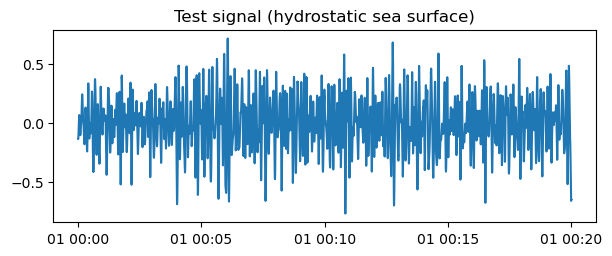

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import detrend, windows
import matplotlib.pyplot as plt
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import transfer_functions as rptf

# Load test data from RBR SoloD pressure sensor
data_root = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
datadir = os.path.join(data_root, 'RBRDuetDT', 'Level1', 'netcdf')
fn = os.path.join(datadir, 'Asilomar_2022_SSA_L1_RBRDuetDT_210358_pressure.nc')
dsp = xr.decode_cf(xr.open_dataset(fn, decode_coords='all'))

# Sampling frequency
fs = 16

# Read/take out test sample (hydrostatic surface)
outdir = '/home/mikapm/Github/Martins_pressure_reconstruction/data'
fn_test = os.path.join(outdir, 'test_data.csv')
if not os.path.isfile(fn_test):
    dt = 0.0625
    t0 = pd.Timestamp('2022-07-01 00:00:00.000000')
    t1 = pd.Timestamp('2022-07-01 00:20:00.000000') - pd.Timedelta(seconds=dt)
    dsp = dsp.sel(time=slice(t0, t1))
    # Make regularly spaced time index
    time_reg = pd.date_range(t0, t1, freq='62500U')
    # Remove possible duplicate samples
    dsp = dsp.sel(time=~dsp.get_index("time").duplicated())
    # Reindex dataset to regular time index
    dsp = dsp.reindex(time=time_reg, method='nearest')
    # Compute (and detrend) hydrostatic surface
    h0 = dsp.z_hyd.mean().item() # Mean water depth
    eta_hyd = detrend(dsp.z_hyd - h0)

    # Save test data in csv format
    dfe = pd.DataFrame(data={'eta_hyd':eta_hyd, 'z_hyd':dsp.z_hyd.values}, 
                       index=time_reg)
    dfe.index = dfe.index.rename('time')
    dfe.to_csv(fn_test)
else:
    dfe = pd.read_csv(fn_test, parse_dates=['time']).set_index('time')
    h0 = dfe['z_hyd'].mean().item()
    eta_hyd = dfe['eta_hyd'].values.squeeze()

# Quick check by plotting eta_hyd
fig, ax = plt.subplots(figsize=(7,2.5))
ax.plot(dfe.index, eta_hyd)
ax.set_title('Test signal (hydrostatic sea surface)')
plt.show()


In [8]:
# Test bispectrum() function in roxsi_pyfuns.wave_spectra
fn_bisp = os.path.join(outdir, 'bispec_test.nc')
if not os.path.isfile(fn_bisp):
    print('Calculating bispectrum ...')
    dsb = rpws.bispectrum(eta_hyd, fs=16, h0=h0, timestamp=dfe.index[0].round('20T'))

    # Test K_rms function
    print('Calculating K_rms ...')
    krms = rptf.k_rms(h0=dsb.h0.item(), f=dsb.freq.values, P=dsb.PST.values, B=dsb.B.values)

    # Save to netcdf
    dsb.to_netcdf(fn_bisp, engine='h5netcdf', invalid_netcdf=True)
else:
    dsb = xr.open_dataset(fn_bisp, engine='h5netcdf')

Calculating bispectrum ...
Calculating K_rms ...


/home/mikapm/Github/pyROXSI/roxsi_pyfuns/transfer_functions.py:159: RuntimeWarning: invalid value encountered in sqrt
  krms[fi] *= np.sqrt(1 + Beta_fr - Beta_am)
/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/h5netcdf/core.py:1208: UserWarning: You are writing invalid netcdf features to file `/home/mikapm/Github/Martins_pressure_reconstruction/data/bispec_test.nc`. The file will thus be not conforming to NetCDF-4 standard and might not be readable by other netcdf tools. Consider using a different extension.
  self.flush()


In [10]:
# Calculate bispectrum from linear surface reconstruction
fn_bisp_lin = os.path.join(outdir, 'bispec_test_etalin.nc')
trf = rptf.TRF(fs=16, zp=0.08)
z_lin = trf.p2eta_lin(dfe['z_hyd'].values)
eta_lin = z_lin - np.mean(z_lin)
if not os.path.isfile(fn_bisp_lin):
    print('Calculating bispectrum ...')
    dsbl = rpws.bispectrum(eta_lin, fs=16, h0=h0, timestamp=dfe.index[0].round('20T'))

    # Save to netcdf
    dsbl.to_netcdf(fn_bisp_lin, engine='h5netcdf', invalid_netcdf=True)
else:
    dsbl = xr.open_dataset(fn_bisp_lin, engine='h5netcdf')

Calculating bispectrum ...


/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/h5netcdf/core.py:1208: UserWarning: You are writing invalid netcdf features to file `/home/mikapm/Github/Martins_pressure_reconstruction/data/bispec_test_etalin.nc`. The file will thus be not conforming to NetCDF-4 standard and might not be readable by other netcdf tools. Consider using a different extension.
  self.flush()


In [9]:
dsb

<xarray.Dataset>
Dimensions:  (freq: 1637, time: 1)
Coordinates:
  * freq     (freq) float64 -7.988 -7.979 -7.969 -7.959 ... 7.969 7.979 7.988
  * time     (time) datetime64[ns] 2022-07-01
Data variables:
    B        (freq, freq) complex128 0j 0j 0j 0j 0j 0j 0j ... 0j 0j 0j 0j 0j 0j
    PST      (freq) float64 7.703e-06 7.638e-06 1.49e-05 ... 9.543e-06 8.326e-06
    fp       (time) float64 0.1228
    kp       (time) float64 0.1067
    h0       (time) float64 6.043
    mu       (time) float64 0.416
    eps      (time) float64 0.07531
    Ur       (time) float64 0.181
    Sk       (time) float64 -0.1207
    As       (time) float64 0.08475
    k_rms    (freq) float64 -148.4 -148.0 -147.7 -147.3 ... 147.7 148.0 148.4
Attributes:
    nfft:                  8192 samples
    overlap:               75%
    nblocks:               7
    fft_window:            rectangular
    merged_frequencies:    5 frequencies
    frequency_resolution:  0.009765625 Hz

## Plot bispectrum
Use logarithmic color scale.

/tmp/ipykernel_1329533/2722474758.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(dsb.freq.values, dsb.freq.values, np.real(dsb.B.values),


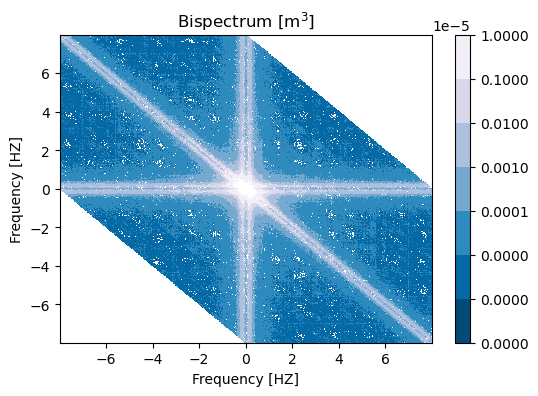

In [17]:
from matplotlib import ticker, cm, colors
vmin = 1e-12
vmax = 1e-4
fig, ax = plt.subplots(figsize=(6,4))
lev_exp = np.arange(np.floor(np.log10(vmin)), np.ceil(np.log10(vmax)))
levs = np.power(10, lev_exp)
cs = ax.contourf(dsb.freq.values, dsb.freq.values, np.real(dsb.B.values),
                 levs, norm=colors.LogNorm(), cmap=cm.PuBu_r)
# cs = ax.contourf(dsb.freq.values, dsb.freq.values, np.real(dsb.B.values), 
#                  locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
ax.set_xlabel('Frequency [HZ]')
ax.set_ylabel('Frequency [HZ]')
ax.set_title(r'Bispectrum [$\mathrm{m}^3$]')
plt.show()
# plt.clf()

## Plot $K_\mathrm{rms}$ vs $K_\mathrm{lin}$

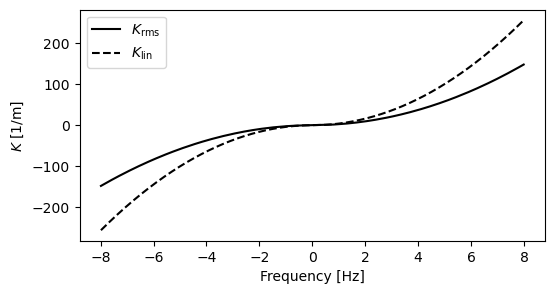

In [24]:
# Compute linear wavenumbers
klin = rptf.waveno_full(dsb.freq.values*np.pi*2, d=dsb.h0.item())

fig, ax = plt.subplots(figsize=(6,3))
ax.plot(dsb.freq.values, krms, label=r'$K_\mathrm{rms}$', color='k')
ax.plot(dsb.freq.values, klin, label=r'$K_\mathrm{lin}$', color='k', linestyle='--')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'$K$ [1/m]')
ax.legend(loc='upper left')
plt.show()